In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
from itertools import product
from scipy.stats import lognorm, norm

DATA_DIR = Path('../data')
MODEL_DIR = Path('../models')

# Import Distribution Models

In [2]:
# Set up

with open(MODEL_DIR / 'siju_lognorm_fits.json', 'r') as infile:
    siju_lognorm_fits = json.load(infile)
    
with open(MODEL_DIR / 'hige_norm_fits.json', 'r') as infile:
    hige_norm_fits = json.load(infile)
    
lobes = [
    "alpha'1", "alpha'2", "alpha'3", 
    'alpha1', 'alpha2', 'alpha3',
    "beta'1", "beta'2", 
    'beta1', 'beta2', 
    'gamma1', 'gamma2', 'gamma3','gamma4', 'gamma5'
]
stimuli = [
    'citronella', 'ethanol', 'heptanone', 
    'hexanol', 'mch', 'octanol',
    'peppermint', 'vinegar', 'yeast'
]

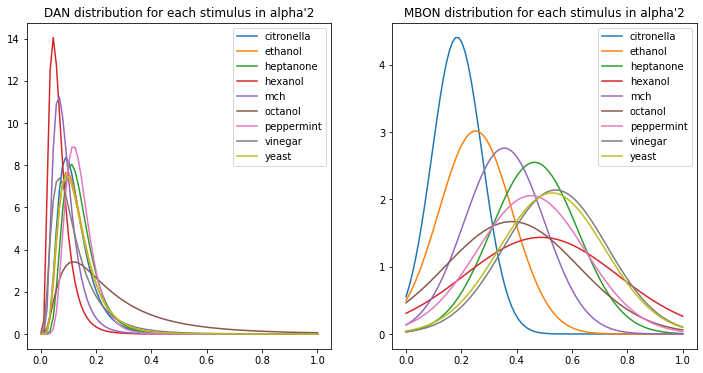

In [3]:
# Visualise

lobe = lobes[1]
x = np.linspace(0,1,90)

fig, axes = plt.subplots(1, 2, figsize=(12,6))

axes[0].set_title(f'DAN distribution for each stimulus in {lobe}')
axes[1].set_title(f'MBON distribution for each stimulus in {lobe}')

for stimulus in stimuli:
    
    siju_params = siju_lognorm_fits[lobe][stimulus]
    siju_rv = lognorm(s=siju_params[0], loc=siju_params[1], scale=siju_params[2])
    y = siju_rv.pdf(x)
    axes[0].plot(x, y, label=stimulus)
        
    hige_params = hige_norm_fits[lobe][stimulus]
    hige_rv = norm(loc=hige_params[0], scale=hige_params[1])
    y = hige_rv.pdf(x)
    axes[1].plot(x, y, label=stimulus)

axes[0].legend()
axes[1].legend()

plt.show()

# Build data matrix from distributions

In [4]:
def build_dataset_from_dist(samples_per_stimulus, stimuli, lobes, hige_norm_fits, siju_lognorm_fits):

    X = np.zeros([len(stimuli) * samples_per_stimulus, len(lobes)])
    Y = np.zeros([len(stimuli) * samples_per_stimulus, len(lobes)])

    for i, stimulus in enumerate(stimuli):
        for j, lobe in enumerate(lobes):
            mbon_params = hige_norm_fits[lobe][stimulus]
            dan_params = siju_lognorm_fits[lobe][stimulus]
            
            mbon_rv = norm(loc=mbon_params[0], scale=mbon_params[1])
            dan_rv = lognorm(s=dan_params[0], loc=dan_params[1], scale=dan_params[2])
            
            X[i*samples_per_stimulus:(i+1)*samples_per_stimulus, j] = dan_rv.rvs(samples_per_stimulus)
            Y[i*samples_per_stimulus:(i+1)*samples_per_stimulus, j] = mbon_rv.rvs(samples_per_stimulus)  

    print(f'Num trials: {samples_per_stimulus}x{len(stimuli)} = {X.shape[0]}')
    print(f'Input shape: {X.shape}')
    print(f'Output shape: {Y.shape}')

    return X, Y

In [5]:
X_train, Y_train = build_dataset_from_dist(
    2000,
    stimuli, 
    lobes,
    hige_norm_fits,
    siju_lognorm_fits
)

Num trials: 2000x9 = 18000
Input shape: (18000, 15)
Output shape: (18000, 15)


In [6]:
X_val, Y_val = build_dataset_from_dist(
    500,
    stimuli, 
    lobes,
    hige_norm_fits,
    siju_lognorm_fits
)

Num trials: 500x9 = 4500
Input shape: (4500, 15)
Output shape: (4500, 15)


In [7]:
X_test, Y_test = build_dataset_from_dist(
    500,
    stimuli, 
    lobes,
    hige_norm_fits,
    siju_lognorm_fits
)

Num trials: 500x9 = 4500
Input shape: (4500, 15)
Output shape: (4500, 15)


In [8]:
np.save(DATA_DIR / 'X-train-from-distribution.npy', X_train, allow_pickle=True)
np.save(DATA_DIR / 'Y-train-from-distribution.npy', Y_train, allow_pickle=True)
np.save(DATA_DIR / 'X-val-from-distribution.npy', X_val, allow_pickle=True)
np.save(DATA_DIR / 'Y-val-from-distribution.npy', Y_val, allow_pickle=True)
np.save(DATA_DIR / 'X-test-from-distribution.npy', X_test, allow_pickle=True)
np.save(DATA_DIR / 'Y-test-from-distribution.npy', Y_test, allow_pickle=True)

# Create Time Series for Each Trial

Data should end up in the shape (num_lobes, time_steps, trials)

In [9]:
# Convert the DAN activity (inputs) into time series
X_e = X_train.T
X_e = np.expand_dims(X_e, axis=1)
Z = np.zeros_like(X_e)
X_ts = np.concatenate((Z, X_e, Z), axis=1)

print(X_ts.shape)

(15, 3, 18000)


In [10]:
# Convert the MBON activity (outputs) into time series

Y_e = np.expand_dims(Y_train.T, axis=1)
Z = np.zeros_like(Y_e)
Y_ts = np.concatenate((Z, Y_e, Z), axis=1)

print(Y_ts.shape)

(15, 3, 18000)


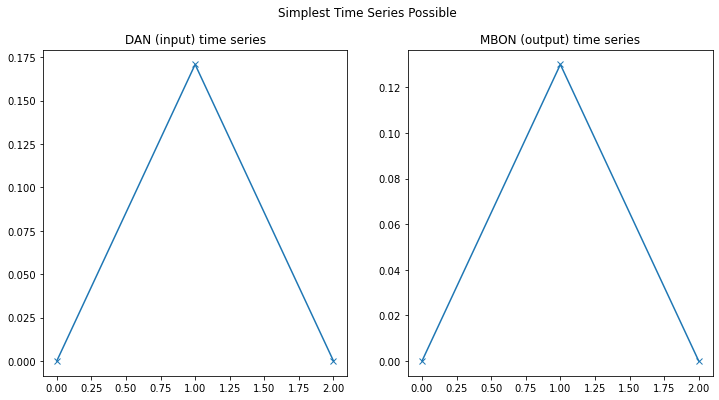

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))
plt.suptitle('Simplest Time Series Possible')

axes[0].set_title(f'DAN (input) time series')
axes[1].set_title(f'MBON (output) time series')

axes[0].plot(X_ts[0, :, 0], 'x-')
axes[1].plot(Y_ts[0, :, 0], 'x-')

plt.show()

In [12]:
# np.save(DATA_DIR / 'X-time-series-from-distribution.npy', X_ts, allow_pickle=True)
# np.save(DATA_DIR / 'Y-time-series-from-distribution.npy', Y_ts, allow_pickle=True)

# Explore using exponential decaying function

In [13]:
def build_exponential_time_series(X, baseline_curve):
    '''Each datapoint in X corresponds to a mean of a time series. 
    This method approximates the timeseries by scaling a baseline 
    function to have the same mean as eavh of those values.'''
    
    nsamples = X.shape[0]
    nfeatures = X.shape[1]
    u = baseline_curve.mean()

    # repeat baseline based on the dataset size
    single_baseline_input = np.repeat(
    np.expand_dims(baseline_curve, axis=0), 
    15, 
    axis=0
    )
    baseline_input = np.repeat(
        np.expand_dims(single_baseline_input, axis=-1), 
        nsamples,
        axis=2
    )

    # scale the baseline
    X_timeseries_data = np.zeros((nfeatures, 10, nsamples))
    for sample in range(nsamples):
        for feat in range(nfeatures):
            scale = X[sample, feat] / u
            X_timeseries_data[feat, : , sample] = baseline_input[feat, : , sample] * scale
    
    return X_timeseries_data

### DAN Exponential Time Series

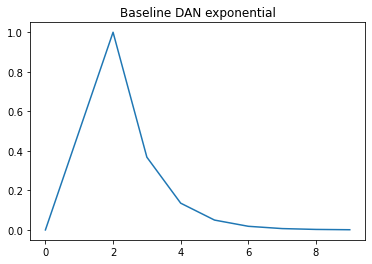

In [14]:
# baseline_curve = np.exp(-np.arange(0,10))
baseline_dan_curve = np.exp(-(np.arange(-2,8)))
baseline_dan_curve[0] = 0
baseline_dan_curve[1] = 0.5

plt.plot(baseline_dan_curve)
plt.title('Baseline DAN exponential')
plt.show()

New dataset shape: (15, 10, 18000)
New val dataset shape: (15, 10, 4500)
New test dataset shape: (15, 10, 4500)


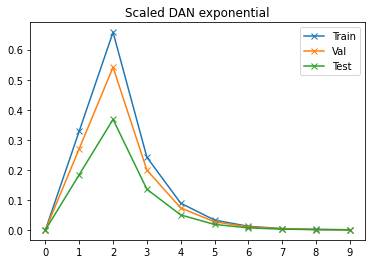

In [15]:
X_train_ts = build_exponential_time_series(X_train, baseline_dan_curve)
X_val_ts = build_exponential_time_series(X_val, baseline_dan_curve)
X_test_ts = build_exponential_time_series(X_test, baseline_dan_curve)

print(f'New dataset shape: {X_train_ts.shape}')
print(f'New val dataset shape: {X_val_ts.shape}')
print(f'New test dataset shape: {X_test_ts.shape}')

plt.plot(X_train_ts[1,:,10], '-x', label='Train')
plt.plot(X_val_ts[1,:,10], '-x', label='Val')
plt.plot(X_test_ts[1,:,10], '-x', label='Test')
plt.title('Scaled DAN exponential')
plt.xticks(range(10))
plt.legend()
plt.show()

In [16]:
# Check that the means of the scaled time series are the same as the real data

assert X_train_ts[1,:,10].mean() == X_train[10, 1]

assert X_val_ts[1,:,10].mean() == X_val[10, 1]

assert X_test_ts[1,:,10].mean() == X_test[10, 1]

### MBON Activity Time Series

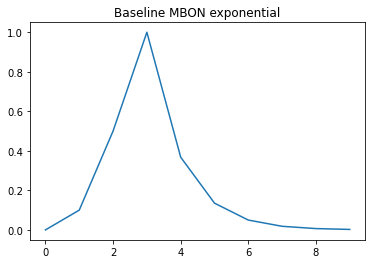

In [18]:
# baseline with offset:
baseline_mbon_curve = np.exp(-(np.arange(-3,7)))
baseline_mbon_curve[0] = 0
baseline_mbon_curve[1] = 0.1
baseline_mbon_curve[2] = 0.5

plt.plot(baseline_mbon_curve)
plt.title('Baseline MBON exponential')
plt.show()

New train dataset shape: (15, 10, 18000)
New val dataset shape: (15, 10, 4500)
New test dataset shape: (15, 10, 4500)


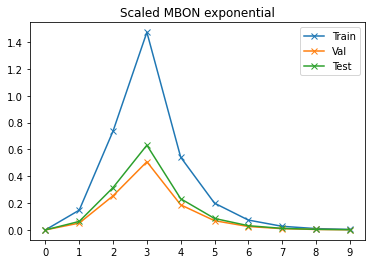

In [19]:
Y_train_ts = build_exponential_time_series(Y_train, baseline_mbon_curve)
Y_val_ts = build_exponential_time_series(Y_val, baseline_mbon_curve)
Y_test_ts = build_exponential_time_series(Y_test, baseline_mbon_curve)

print(f'New train dataset shape: {Y_train_ts.shape}')
print(f'New val dataset shape: {Y_val_ts.shape}')
print(f'New test dataset shape: {Y_test_ts.shape}')

plt.plot(Y_train_ts[1,:,10], '-x', label='Train')
plt.plot(Y_val_ts[1,:,10], '-x', label='Val')
plt.plot(Y_test_ts[1,:,10], '-x', label='Test')

plt.xticks(range(10))
plt.title('Scaled MBON exponential')
plt.legend()
plt.show()

In [20]:
np.save(DATA_DIR / 'X-train-exp-time-series-from-distribution.npy', X_train_ts, allow_pickle=True)
np.save(DATA_DIR / 'Y-train-exp-time-series-from-distribution.npy', Y_train_ts, allow_pickle=True)
np.save(DATA_DIR / 'X-val-exp-time-series-from-distribution.npy', X_val_ts, allow_pickle=True)
np.save(DATA_DIR / 'Y-val-exp-time-series-from-distribution.npy', Y_val_ts, allow_pickle=True)
np.save(DATA_DIR / 'X-test-exp-time-series-from-distribution.npy', X_test_ts, allow_pickle=True)
np.save(DATA_DIR / 'Y-test-exp-time-series-from-distribution.npy', Y_test_ts, allow_pickle=True)

# Try use the average value rather than just scaling

In [21]:
# scale the baseline
X_timeseries_data = np.zeros((nfeatures, 10, nsamples))
for sample in range(nsamples):
    for feat in range(nfeatures):
        scale = X[sample, feat]
        X_timeseries_data[feat, : , sample] = baseline_input[feat, : , sample] * scale

NameError: name 'nfeatures' is not defined

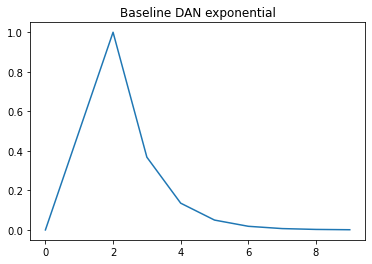

In [21]:
baseline_dan_curve = np.exp(-(np.arange(-2,8)))
baseline_dan_curve[0] = 0
baseline_dan_curve[1] = 0.5

plt.plot(baseline_dan_curve)
plt.title('Baseline DAN exponential')
plt.show()

In [22]:
baseline_dan_curve

array([0.00000000e+00, 5.00000000e-01, 1.00000000e+00, 3.67879441e-01,
       1.35335283e-01, 4.97870684e-02, 1.83156389e-02, 6.73794700e-03,
       2.47875218e-03, 9.11881966e-04])

In [23]:
sample = 10
feature = 0
X_train[sample,feature]

0.14116753264693482

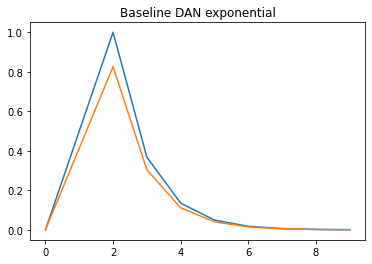

In [26]:
u = baseline_dan_curve.mean()
scaled_baseline = baseline_dan_curve * X_train[sample,feature] / u

plt.plot(baseline_dan_curve)
plt.plot(scaled_baseline)
plt.title('Baseline DAN exponential')
plt.show()

In [27]:
X_train[sample,feature] / u

0.825880463987541

In [28]:
scaled_baseline.mean()

0.1719025598821203